In [1]:
import json
import os
from pathlib import Path

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import omero.clients
import seaborn as sns
import scanpy as sc
import tifffile
from einops import rearrange
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from skimage.measure import regionprops
from omero.gateway import BlitzGateway

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mip.utils as utils

## load in data

In [5]:
# os.environ["OMERO_PASSWORD"] = ''

In [6]:
group = 'HTAN'
project = 'CODEX_initial'
username = 'estorrs'
password = os.environ["OMERO_PASSWORD"]
host = 'htan-imaging.wucon.wustl.edu'
port = '4064'

In [7]:
conn = BlitzGateway(username, password, host=host, port=port,
                    secure=True, group=group)
conn.connect()

True

In [8]:
project = next(iter(conn.getObjects("Project", attributes={"name": project})))

In [9]:
# list out all images in the project
name_to_img = {}
for dataset in project.listChildren():
    for img in dataset.listChildren():
        name_to_img[f'{dataset.getName()} | {img.getName()}'] = img
sorted(name_to_img.keys())

['E16.5_female_section1_04272023 | E16.5_female_section1_04272023',
 'E16.5_female_section2_04272023 | E16.5_female_section2_04272023',
 'E16.5_male_section1_04272023 | E16.5_male_section1_04272023',
 'E16.5_male_section2_04272023 | E16.5_male_section2_04272023',
 'HT110B1_S1H4 | HT110B1_S1H4',
 'HT112C1 | HT112C1',
 'HT171B1-S1H9A1-4_04192023 | HT171B1-S1H9A1-4_04192023',
 'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff',
 'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff',
 'HT171B1_S1H1A1_11182022 | HT171B1_S1H1A1_11182022',
 'HT171B1_S1H1A1_12022022 | HT171B1_S1H1A1_12022022',
 'HT171B1_S1H1A1_20221122 | HT171B1_S1H1A1_20221122',
 'HT171B1_S1H1A4_11182022 | HT171B1_S1H1A4_11182022',
 'HT171B1_S1H1A4_12022022 | HT171B1_S1H1A4_12022022',
 'HT171B1_S1H1A4_20221205 | HT171B1_S1H1A4_20221205',
 'HT206B1_Ctrl_from_Marrow_179 | HT206B1_Ctrl_from_Marrow_179',
 'HT206B1_H1 | HT206B1_H1',
 'HT206B1_H1_06252022 | HT206B1_H1_06252022',
 'HT20

In [12]:
names = [
    'HT342C1_Th1K4A1_section1_03042022 | HT342C1_Th1K4A1_section1_03042022',
    'HT342C1_Th1K4A1_section2_03042022 | HT342C1_Th1K4A1_section2_03042022',
    'HT347C1_Th1K2A1_section1_03042022 | HT347C1_Th1K2A1_section1_03042022',
    'HT347C1_Th1K2A1_section2_03042022 | HT347C1_Th1K2A1_section2_03042022',
    'HT413C1-K2_04262023 | HT413C1-K2_04262023',
    'HT427P1_S1H1A3_20221020 | HT427P1_S1H1A3_20221020',
    'HT434P1_H1 | HT434P1_H1',
    'HT488C1-Th1K1Fp1-U14_041823 | HT488C1-Th1K1Fp1-U14_041823',
    'HT488C1-Th1K1Fp1-U2_041323 | HT488C1-Th1K1Fp1-U2_041323',
    'HT553P1-H2_04262023 | HT553P1-H2_04262023',
    'HT565B1-H2_04262023 | HT565B1-H2_04262023',
]

In [13]:
channel_thresholds = {}
for name in names:
    img = name_to_img[name]
    rendering_defs = img.getAllRenderingDefs()
    channel_metadata = rendering_defs[0]['c']
    thresholds = [c['start'] for c in channel_metadata]
    
    if np.asarray(thresholds).sum() == 0:
        print('warning: all thresholds are zero. maybe they are not set for this image?', name)

    channel_thresholds[name] = thresholds
print('{')
for k in channel_thresholds.keys():
    print(f"'{k}': ")
print('}')
# set(channel_thresholds.keys())

{
'HT110B1_S1H4 | HT110B1_S1H4': 
'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff': 
'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff': 
'HT206B1_H1 | HT206B1_H1': 
'HT206B1_H1_06252022 | HT206B1_H1_06252022': 
'HT206B1_S1H2L4_20221020 | HT206B1_S1H2L4_20221020': 
'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028': 
'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023': 
'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff': 
'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff': 
'HT243B1_S1H4 | HT243B1_S1H4': 
'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023': 
'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff': 
'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff': 
'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023': 
'HT297B1_H1_08042022 | HT297B1_H1_08042022': 
'HT305B1_S1H1 | HT305B1_S1H1': 
'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023': 
'HT308

In [14]:
conn.close()

In [15]:
ome_fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/',
                                 regex=r'level_2/[^/]+.ome.tiff$'))
seg_fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/',
                                 regex=r'level_3.*cell_seg.*.tif$'))

sample_to_ome = {fp.split('/')[-1].replace('.ome.tiff', '') + '_' + fp.split('/')[-3]:fp for fp in ome_fps}
sample_to_seg = {fp.split('/')[-1].replace('_cell_segmentation.tif', '') + '_' + fp.split('/')[-4]:fp for fp in seg_fps}

for sample in sorted(sample_to_ome.keys()):
    if sample in sample_to_ome and sample in sample_to_seg:
        ome_fp, seg_fp = sample_to_ome[sample], sample_to_seg[sample]
        print('{' + f"'img': '{ome_fp}', 'seg': '{seg_fp}'" + '},')


{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT110B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT110B1-S1H4_cell_segmentation.tif'},
{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1-S1H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_3/segmentation/HT171B1-S1H1A1_cell_segmentation.tif'},
{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1-S1H1A4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_3/segmentation/HT171B1-S1H1A4_cell_segmentation.tif'},
{'img': '/diskmnt/Projec

In [16]:
mapping = {
    'HT110B1_S1H4 | HT110B1_S1H4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT110B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT110B1-S1H4_cell_segmentation.tif'},
    'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT171B1-S1H9A1-4_left_05122023_cell_segmentation.tif'},
    'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT171B1-S1H9A1-4_right_05122023_cell_segmentation.tif'},
    'HT206B1_H1 | HT206B1_H1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_2/HT206B1-H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_3/segmentation/HT206B1-H1_cell_segmentation.tif'},
    'HT206B1_H1_06252022 | HT206B1_H1_06252022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_2/HT206B1_H1_06252022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_3/segmentation/HT206B1_H1_06252022_cell_segmentation.tif'},
#     'HT206B1_S1H2L4_20221020 | HT206B1_S1H2L4_20221020': 
    'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_2/HT206B1_S1H2L4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_3/segmentation/HT206B1_S1H2L4_cell_segmentation.tif'},
    'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT243B1-S1H4A4_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT243B1-S1H4A4_04192023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT243B1-S1H4A4_left_05122023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT243B1-S1H4A4_right_05122023_cell_segmentation.tif'},
    'HT243B1_S1H4 | HT243B1_S1H4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT243B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT243B1-S1H4_cell_segmentation.tif'},
    'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT271B1-S1H6A5_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT271B1-S1H6A5_04192023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT271B1-S1H6A5_left_05122023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT271B1-S1H6A5_right_05122023_cell_segmentation.tif'},
    'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_2/HT271B1_S1H3A5.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation/HT271B1_S1H3A5_cell_segmentation.tif'},
#     'HT297B1_H1_08042022 | HT297B1_H1_08042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT297B1-H1-08042022/level_2/HT297B1-H1-08042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT297B1-H1-08042022/level_3/segmentation/HT297B1-H1-08042022_cell_segmentation.tif'},
    'HT305B1_S1H1 | HT305B1_S1H1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT305B1-S1H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT305B1-S1H1_cell_segmentation.tif'},
    'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT308B1-S1H5A4_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT308B1-S1H5A4_04192023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT308B1-S1H5A4_left_05122023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_right_05122023 | HT308B1-S1H5A4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT308B1-S1H5A4_right_05122023_cell_segmentation.tif'},
    'HT323B1_H1A1 | HT323B1_H1A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A1/level_2/HT323B1-H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A1/level_3/segmentation/HT323B1-H1A1_cell_segmentation.tif'},
    'HT323B1_H1A4 | HT323B1_H1A4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A4/level_2/HT323B1-H1A4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A4/level_3/segmentation/HT323B1-H1A4_cell_segmentation.tif'},
    'HT323B1_H1_08042022 | HT323B1_H1_08042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1-08042022/level_2/HT323B1-H1-08042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1-08042022/level_3/segmentation/HT323B1-H1-08042022_cell_segmentation.tif'},
    'HT323B1_H3 | HT323B1_H3': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H3/level_2/HT323B1-H3.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H3/level_3/segmentation/HT323B1-H3_cell_segmentation.tif'},
    'HT339B1_H1A1 | HT339B1_H1A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H1A1/level_2/HT339B1-H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H1A1/level_3/segmentation/HT339B1-H1A1_cell_segmentation.tif'},
    'HT339B1_H2A1 | HT339B1_H2A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H2A1/level_2/HT339B1-H2A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H2A1/level_3/segmentation/HT339B1-H2A1_cell_segmentation.tif'},
#     'HT339B1_H4A4 | HT339B1_H4A4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H4A4/level_2/HT339B1-H4A4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H4A4/level_3/segmentation/HT339B1-H4A4_cell_segmentation.tif'},
    'HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_2/HT365B1_S1H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation/HT365B1_S1H1_cell_segmentation.tif'},
    'HT397B1_H2A2 | HT397B1_H2A2': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H2A2/level_2/HT397B1-H2A2.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H2A2/level_3/segmentation/HT397B1-H2A2_cell_segmentation.tif'},
    'HT397B1_H3A1 | HT397B1_H3A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H3A1/level_2/HT397B1-H3A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H3A1/level_3/segmentation/HT397B1-H3A1_cell_segmentation.tif'},
    'HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_3/segmentation/HT397B1_S1H1A3U22_04122023_cell_segmentation.tif'},
    'HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_3/segmentation/HT397B1_S1H1A3U31_04062023_cell_segmentation.tif'},
    'HT397B1_U12_03172023 | HT397B1_U12_03172023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation/HT397B1_U12_03172023_cell_segmentation.tif'},
    'HT397B1_U2_03162023 | HT397B1_U2_03162023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation/HT397B1_U2_03162023_cell_segmentation.tif'},
    'HT480B1_S1H2_R001 | HT480B1_S1H2_R001': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg001/level_2/HT480B1-S1H2-R001.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg001/level_3/segmentation/HT480B1-S1H2-R001_cell_segmentation.tif'},
    'HT480B1_S1H2_R002 | HT480B1_S1H2_R002': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg002/level_2/HT480B1-S1H2-R002.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg002/level_3/segmentation/HT480B1-S1H2-R002_cell_segmentation.tif'},
    'HT565B1-H2_04262023 | HT565B1-H2_04262023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT565B1-H2_04262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_3/segmentation/HT565B1-H2_04262023_cell_segmentation.tif'},
}


In [17]:
channel_mapping = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45RO'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)'],
    'ER': ['ER', 'ER-(D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN']
}
r_channel_mapping = {v:k for k, vs in channel_mapping.items() for v in vs}

In [18]:
def generate_feature_table(ome_fp, seg_fp, thresholds):
    channels, imgs = utils.extract_ome_tiff(ome_fp, as_dict=False)
    assert len(channels) == len(thresholds)
    
    seg = tifffile.imread(seg_fp)
    thresholds = np.asarray(thresholds) # make sure numpy
    
    masks = rearrange(
        rearrange(imgs, 'c h w -> h w c') > thresholds,
        'h w c -> c h w')
    
    props = regionprops(seg)
    
    data = []
    for i, prop in enumerate(props):
        label = i + 1
        row = []
        r1, c1, r2, c2 = prop['bbox']

        area = prop['area']
        seg_tile = seg[r1:r2, c1:c2]
        imgs_tile = imgs[..., r1:r2, c1:c2]
        masks_tile = masks[..., r1:r2, c1:c2]

        cell_mask = seg_tile==label

        row = [label, prop['centroid'][0], prop['centroid'][1], r1, c1, r2, c2, area]
        for j in range(imgs_tile.shape[0]):
            img, mask = imgs_tile[j], masks_tile[j]
            counts = (cell_mask & mask).sum()
            row.append(counts / area)
            
            intensity = img[cell_mask].mean()
            row.append(intensity)

        data.append(row)

    cols = ['label', 'row', 'col', 'bbox-r1', 'bbox-c1', 'bbox-r2', 'bbox-c2', 'area']
    for c in channels:
        converted = r_channel_mapping.get(c, c)
        for identifier in ['fraction', 'intensity']:
            cols.append(f'{converted}_{identifier}')
    df = pd.DataFrame(data=data, columns=cols)
    return df


In [19]:
name_to_features = {}
for name in mapping.keys():
    print(name)
    df = generate_feature_table(mapping[name]['img'], mapping[name]['seg'], channel_thresholds[name])
    name_to_features[name] = df

HT110B1_S1H4 | HT110B1_S1H4
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff
HT206B1_H1 | HT206B1_H1
HT206B1_H1_06252022 | HT206B1_H1_06252022
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028
HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff
HT243B1_S1H4 | HT243B1_S1H4
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023
HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff
HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff
HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023
HT305B1_S1H1 | HT305B1_S1H1
HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff
HT308B1-S1H5A4_right_05122023 | HT308B1-S1H5A4_right_05122023.ome.tiff
HT323B1_H1A1 | HT323B1_H1A1
HT32

In [20]:
mapping.keys()

dict_keys(['HT110B1_S1H4 | HT110B1_S1H4', 'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'HT206B1_H1 | HT206B1_H1', 'HT206B1_H1_06252022 | HT206B1_H1_06252022', 'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028', 'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023', 'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff', 'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff', 'HT243B1_S1H4 | HT243B1_S1H4', 'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023', 'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff', 'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff', 'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023', 'HT305B1_S1H1 | HT305B1_S1H1', 'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023', 'HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff', 'HT308B1-S1H5A4_right_05122023 | HT308B1-

In [21]:
channel_thresholds['HT110B1_S1H4 | HT110B1_S1H4']

[0.0,
 10.0,
 0.0,
 254.0,
 0.0,
 50.0,
 0.0,
 9.0,
 39.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 19.0,
 254.0,
 12.0,
 0.0,
 15.0,
 19.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [22]:
default = .05
gating_strategy = [
    {
        'name': 'Treg',
        'strategy': [
            {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
            {'channel': 'CD4', 'value': default, 'direction': 'pos'},
            {'channel': 'FOXP3', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'CD4 T cell',
        'strategy': [
            {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
            {'channel': 'CD4', 'value': default, 'direction': 'pos'},
        ],
    },
        {
        'name': 'CD8 T cell',
        'strategy': [
            {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
            {'channel': 'CD8', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'B cell',
        'strategy': [
            {'channel': 'CD20', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Macrophage - M1',
        'strategy': [
            {'channel': 'CD68', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Macrophage - M2',
        'strategy': [
            {'channel': 'CD68', 'value': default, 'direction': 'pos'},
            {'channel': 'CD163', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Endothelial',
        'strategy': [
            {'channel': 'CD31', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD45', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD68', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD163', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Epithelial',
        'strategy': [
            {'channel': 'Pan-Cytokeratin', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Epithelial',
        'strategy': [
            {'channel': 'E-cadherin', 'value': default, 'direction': 'pos'}
        ],
    },
#     {
#         'name': 'Myoepithelial',
#         'strategy': [
#             {'channel': 'CK14', 'value': default, 'direction': 'pos'},
#         ],
#     },
#     {
#         'name': 'Myoepithelial',
#         'strategy': [
#             {'channel': 'CK5', 'value': default, 'direction': 'pos'},
#         ],
#     },
    {
        'name': 'Stroma',
        'strategy': [
            {'channel': 'SMA', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Stroma',
        'strategy': [
            {'channel': 'Podoplanin', 'value': default, 'direction': 'pos'},
        ],
    },
]

In [40]:


for name, df in name_to_features.items():
    markers = [c.replace('_fraction', '') for c in df.columns if '_fraction' in c]
    print(markers)
    cell_types = np.asarray(['Unlabeled'] * df.shape[0], dtype=object)
    for d in gating_strategy:
        is_valid = cell_types=='Unlabeled'
        mask = np.ones_like(cell_types, dtype=np.bool)
        for strategy in d['strategy']:
            channel, val = strategy['channel'], strategy['value']
            threshold = channel_thresholds[name][markers.index(channel)] if channel in markers else 0
            x = df[f'{channel}_fraction'].to_list()[0] if f'{channel}_fraction' in df.columns else 0
            print(name, threshold, x)
            if pd.isnull(x) or threshold==0:
                if len(d) == 1:
                    m = np.ones_like(mask, dtype=np.bool)
                else:
                    m = np.zeros_like(mask, dtype=np.bool)
            elif strategy['direction'] == 'pos': 
                m = df[f'{channel}_fraction'] >= val
            else:
                m = df[f'{channel}_fraction'] < val
            mask &= m

        if ~mask.sum() == 0: # if all true then pass bc that means marker isn't present or something is wrong with gate
            pass
        else:
            mask &= is_valid
            cell_types[mask] = d['name']
    df['cell_type'] = cell_types
    name_to_features[name] = df

['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CK17', 'HLA-DR', 'GATA3', 'CD36', 'MGP', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD3e', 'CD163', 'Ki67', 'PR', 'ER', 'P16', 'CK19', 'P21 (D)']
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 10.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 12.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 19.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 19.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 50.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 19.0 0.0


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


HT110B1_S1H4 | HT110B1_S1H4 9.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3 (D)', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1']
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 14.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 0 0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 14.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 254.0 0.0
HT171B1-S1H

HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 0 0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 10.0 0.0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 10.0 0.1768901569186876
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 0 0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 15.0 0.0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 0.0 0.34522111269614836
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 10.0 0.0014265335235378032
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 10.0 0.1768901569186876
['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cytokeratin', 'GLUT

HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023 0 0
HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023 20.0 0.3512476007677543
HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023 0.0 0.8675623800383877
HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023 10.0 0.5796545105566219
HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023 15.0 0.5163147792706334
['DAPI', 'CD8', 'Her2', 'GATA3 (D)', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1']
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 10.0 0.2769367764915405
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 14.0 0.2769367764915405
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 0 0
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 10.0 0.276936776491540

HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 1200.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 0.0 0.8
HT323B1_H3 | HT323B1_H3 2000.0 0.0
HT323B1_H3 | HT323B1_H3 5499.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'MGP', 'beta-integrin', 'Podoplanin', 'CD3e', 'CK17', 'HIF1a', 'GLUT1', 'GATA3', 'P63', 'Histone H3 Pho', 'SMA', 'CK19', 'MLPH', 'Vimentin', 'Maspin', 'FOXP3', 'CD163', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'GP2', 'cKit', 'COX2', 'Lyve-1']
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 65534.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 65534.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1

HT397B1_U12_03172023 | HT397B1_U12_03172023 0 0
HT397B1_U12_03172023 | HT397B1_U12_03172023 254.0 0.0
HT397B1_U12_03172023 | HT397B1_U12_03172023 0 0
HT397B1_U12_03172023 | HT397B1_U12_03172023 50.0 0.0
HT397B1_U12_03172023 | HT397B1_U12_03172023 0 0
HT397B1_U12_03172023 | HT397B1_U12_03172023 13.0 0.0
HT397B1_U12_03172023 | HT397B1_U12_03172023 8.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3 (D)', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
HT397B1_U2_03162023 | HT397B1_U2_03162023 8.0 0.6292134831460674
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
HT397B1_U2_03162023 | HT397B1_U2_03162023 10.0 0.3595505617977528
HT397B1_U2_03162023 | HT397B1_U2_03162023 10.0 0.62921

In [31]:
# combined = None
# for name, df in name_to_features.items():
#     df['name'] = name
#     if combined is None:
#         combined = df
#     else:
#         combined = pd.concat((combined, df))
# combined

In [32]:
order = sorted({d['name'] for d in gating_strategy})
order.append('Unlabeled')

order

['B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Endothelial',
 'Epithelial',
 'Immune',
 'Macrophage - M1',
 'Macrophage - M2',
 'Stroma',
 'Treg',
 'Unlabeled']

In [33]:
name_to_features.keys()

dict_keys(['HT110B1_S1H4 | HT110B1_S1H4', 'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'HT206B1_H1 | HT206B1_H1', 'HT206B1_H1_06252022 | HT206B1_H1_06252022', 'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028', 'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023', 'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff', 'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff', 'HT243B1_S1H4 | HT243B1_S1H4', 'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023', 'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff', 'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff', 'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023', 'HT305B1_S1H1 | HT305B1_S1H1', 'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023', 'HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff', 'HT308B1-S1H5A4_right_05122023 | HT308B1-

In [34]:
name_to_features['HT565B1-H2_04262023 | HT565B1-H2_04262023']

label           row           col  bbox-r1  bbox-c1  bbox-r2  bbox-c2  \
0          1   2508.323843  12305.628114     2497    12289     2526    12319   
1          2   2837.180702   2919.773684     2819     2907     2853     2933   
2          3   2912.824859   2911.836158     2906     2904     2922     2921   
3          4   2918.194651   2938.060921     2906     2919     2934     2955   
4          5   2928.295455   2899.454545     2919     2892     2939     2908   
...      ...           ...           ...      ...      ...      ...      ...   
69329  69330  14795.395480   5711.163842    14789     5700    14800     5722   
69330  69331  14795.834356   5843.509202    14792     5833    14800     5856   
69331  69332  14796.426230   7539.754098    14793     7535    14800     7546   
69332  69333  14796.118182   7641.600000    14792     7634    14800     7651   
69333  69334  14796.229730   3757.594595    14792     3752    14800     3764   

       area  DAPI_fraction  DAPI_intensity  ...  CTLA4_intensity  \
0       562            0.0        0.000000  ...        13.770463   
1       570            1.0       13.622807  ...         0.584211   
2       177            1.0       12.830508  ...         0.446328   
3       673            1.0       18.915305  ...         0.421991   
4       220            1.0       11.768182  ...         0.445455   
...     ...            ...             ...  ...              ...   
69329   177            1.0       77.751412  ...         8.169492   
69330   163            1.0       30.858896  ...         0.000000   
69331    61            1.0       16.311475  ...         0.672131   
69332   110            1.0       26.945455  ...         0.390909   
69333    74            1.0       31.527027  ...         2.878378   

       Hep-Par-1 (D)_fraction  Hep-Par-1 (D)_intensity  CD4_fraction  \
0                    0.971530                 4.667260           0.0   
1                    0.968421                 5.292982           0.0   
2                    0.983051                 5.288136           0.0   
3                    1.000000                 9.774146           0.0   
4                    0.840909                 2.268182           0.0   
...                       ...                      ...           ...   
69329                0.644068                 1.288136           0.0   
69330                0.171779                 0.171779           0.0   
69331                1.000000                 2.524590           0.0   
69332                0.863636                 1.027273           0.0   
69333                1.000000                 4.445946           0.0   

       CD4_intensity  SLC39A6_fraction  SLC39A6_intensity  CK5_fraction  \
0          12.040925          0.971530           6.117438           0.0   
1           0.594737          0.522807           0.973684           0.0   
2           0.790960          0.384181           0.677966           0.0   
3           0.885587          0.454681           0.832095           0.0   
4           0.890909          0.518182           0.986364           0.0   
...              ...               ...                ...           ...   
69329       7.553672          0.785311           4.627119           0.0   
69330       0.325153          0.110429           0.147239           0.0   
69331       6.016393          0.901639           2.950820           0.0   
69332       2.781818          0.518182           0.700000           0.0   
69333      15.554054          1.000000           6.567568           1.0   

       CK5_intensity  cell_type  
0           2.368327  Unlabeled  
1           2.740351  Unlabeled  
2           1.824859  Unlabeled  
3           3.543834  Unlabeled  
4           1.472727  Unlabeled  
...              ...        ...  
69329       3.158192  Unlabeled  
69330       1.104294  Unlabeled  
69331       6.688525  Unlabeled  
69332       1.309091  Unlabeled  
69333     121.229730  Unlabeled  

[69334 rows x 75 columns]

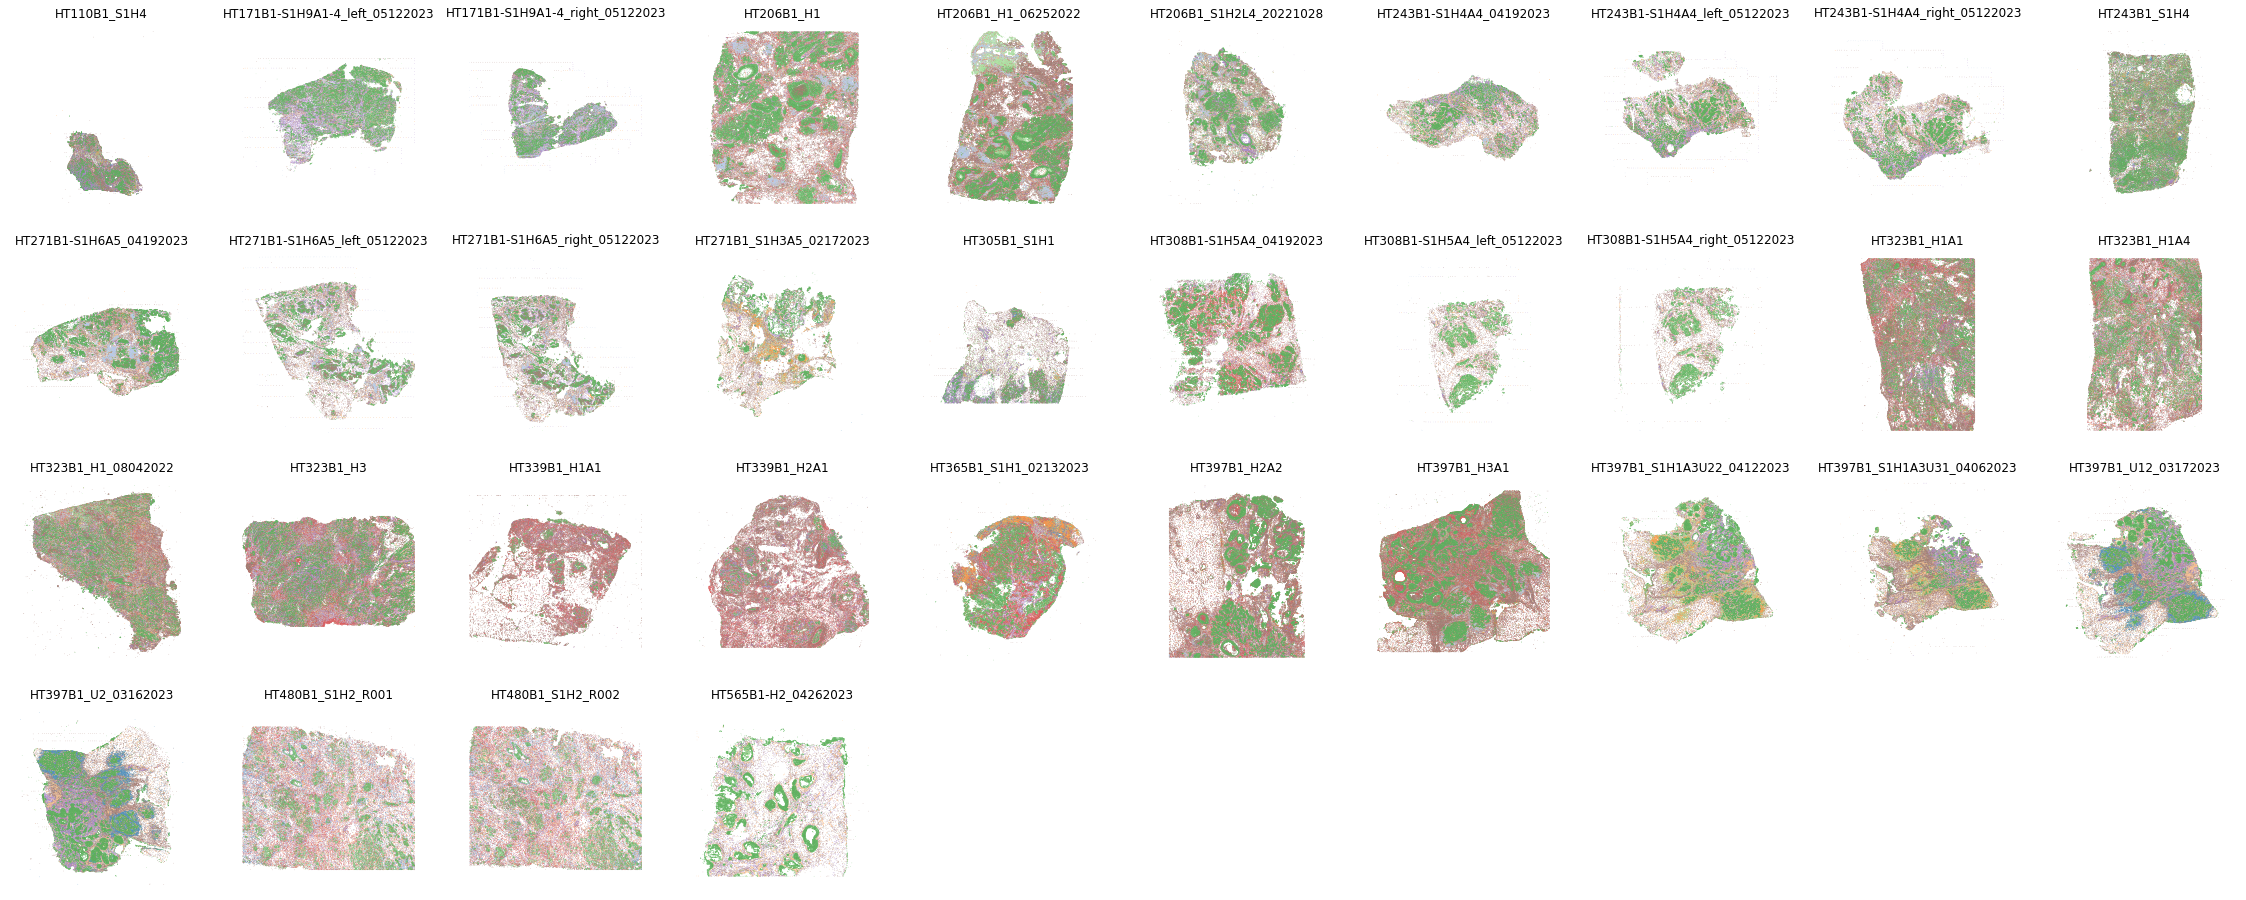

In [41]:
ncols = 10
nrows = (len(name_to_features) // ncols) + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

queue = sorted(name_to_features.keys())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        if len(queue):
            name = queue.pop(0)
            f = name_to_features[name]
            sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.2, hue_order=order,
                            ax=ax, palette='tab20')
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(name.split(' | ')[0])

            leg = ax.get_legend()
            if leg is not None:
                leg.remove()
            
    
        else:
            ax.axis('off')
            
            

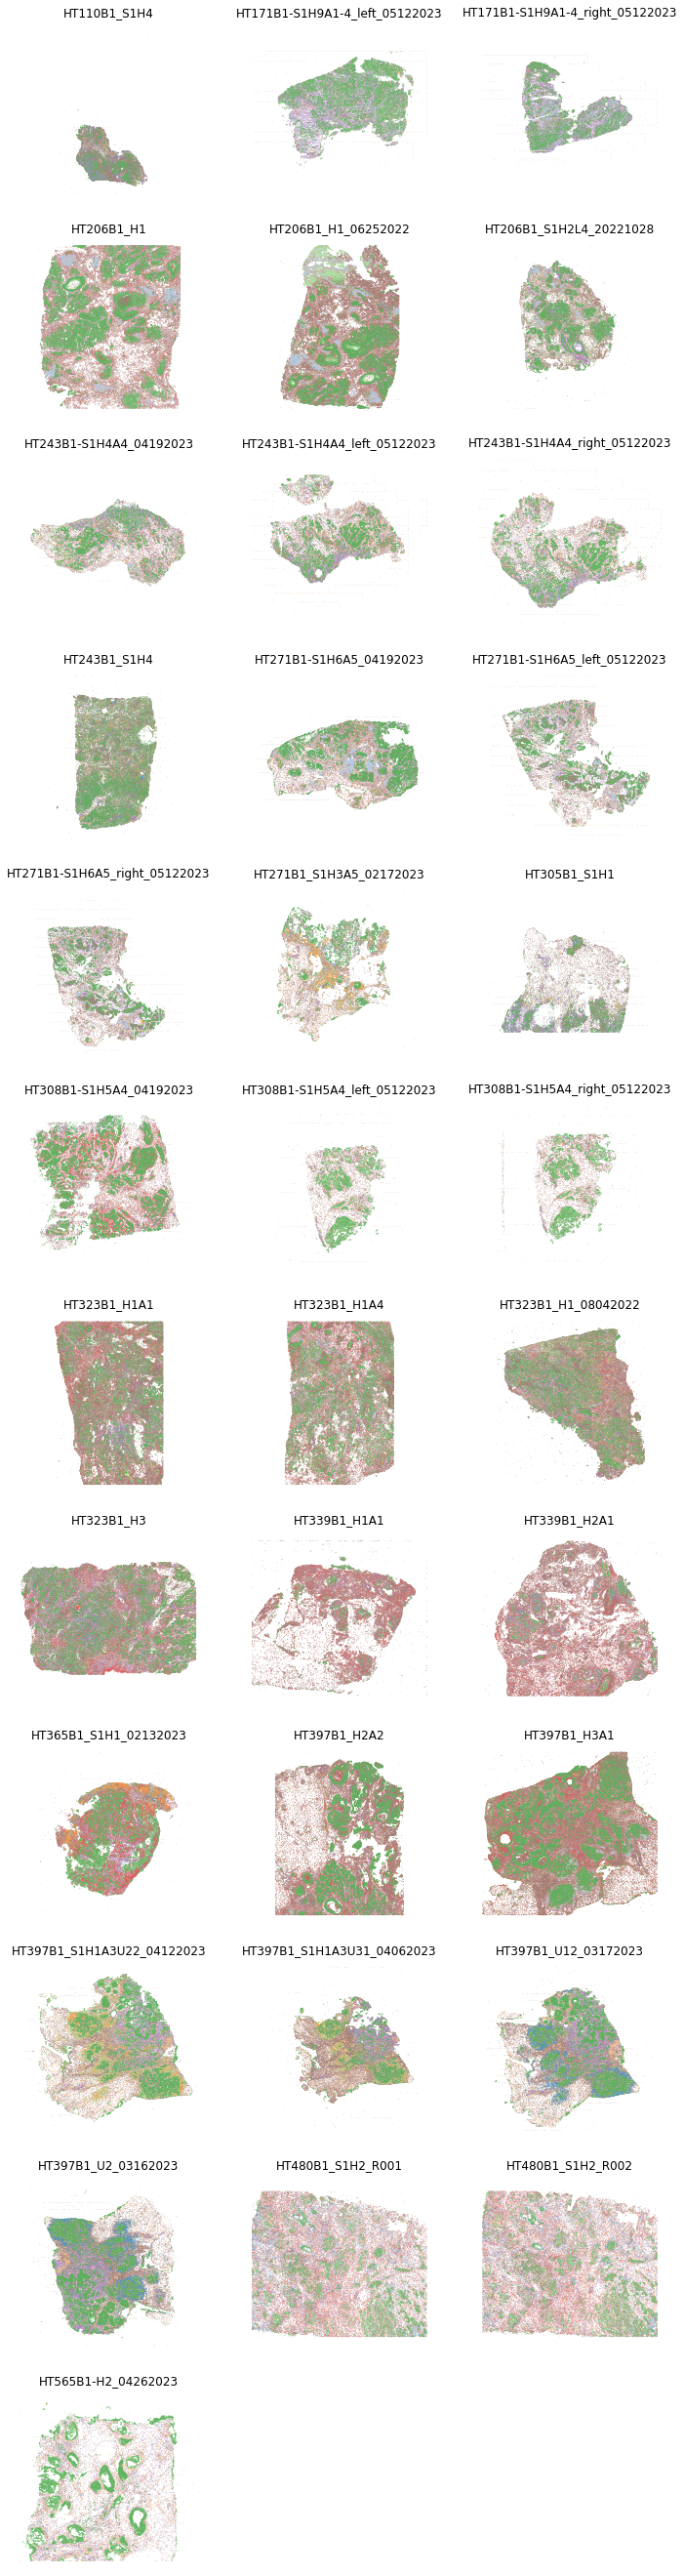

In [42]:
ncols = 3
nrows = (len(name_to_features) // ncols) + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

queue = sorted(name_to_features.keys())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        if len(queue):
            name = queue.pop(0)
            f = name_to_features[name]
            sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.2, hue_order=order,
                            ax=ax, palette='tab20')
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(name.split(' | ')[0])

            leg = ax.get_legend()
            if leg is not None:
                leg.remove()
            
    
        else:
            ax.axis('off')
            
            

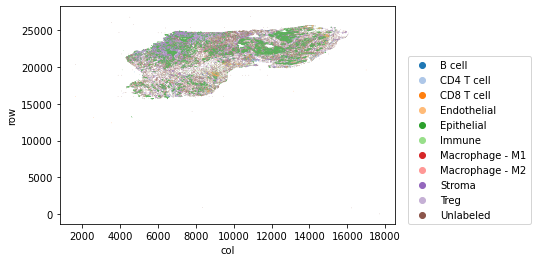

In [38]:
name = 'HT110B1_S1H4 | HT110B1_S1H4'
f = name_to_features[name]
sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.2, hue_order=order, palette='tab20')
plt.legend(loc=(1.04, 0))

In [31]:
combined['omero_dataset'] = [n.split(' | ')[0] for n in combined['name']]
combined['omero_image'] = [n.split(' | ')[1] for n in combined['name']]
combined['row'], combined['col'] = [int(x) for x in combined['row']], [int(x) for x in combined['col']]

In [32]:
combined.to_csv('/diskmnt/Projects/Users/estorrs/sandbox/HT397B1_serial_features.txt', sep='\t', index=False)

In [26]:
name_to_features.keys()

dict_keys(['HT110B1_S1H4 | HT110B1_S1H4', 'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'HT206B1_H1 | HT206B1_H1', 'HT206B1_H1_06252022 | HT206B1_H1_06252022', 'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028', 'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023', 'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff', 'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff', 'HT243B1_S1H4 | HT243B1_S1H4', 'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023', 'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff', 'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff', 'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023', 'HT297B1_H1_08042022 | HT297B1_H1_08042022', 'HT305B1_S1H1 | HT305B1_S1H1', 'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023', 'HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tif

In [25]:
import anndata

ERROR! Session/line number was not unique in database. History logging moved to new session 485


In [43]:
for name, f in name_to_features.items():
    print(name)    
    val_cols = [c for c in f.columns if '_fraction' in c]
    meta = f[[c for c in f.columns if c not in val_cols]]
    meta = meta.set_index('label')
    a = anndata.AnnData(X=f[val_cols].values.astype(np.float32), obs=meta)
    a.var.index = val_cols
    
    a.uns['thresholds'] = channel_thresholds[name]
    a.uns['gating_strategy'] = json.dumps(gating_strategy)
    
    a.obsm['spatial'] = meta[['col', 'row']].values
    
    root = mapping[name]['img'].split('/level_')[0]

    level_4 = os.path.join(root, 'level_4')
    Path(level_4).mkdir(parents=True, exist_ok=True)
    
    identifier = name.split(' | ')[-1].replace('.ome.tiff', '')
    a.write_h5ad(os.path.join(level_4, f'{identifier}.h5ad'))
    f.to_csv(os.path.join(level_4, f'{identifier}.txt'), sep='\t')
    
    print(os.path.join(level_4, f'{identifier}.h5ad'))
    

HT110B1_S1H4 | HT110B1_S1H4


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_4/HT110B1_S1H4.h5ad
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff
/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_4/HT171B1-S1H9A1-4_left_05122023.h5ad
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff
/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_4/HT171B1-S1H9A1-4_right_05122023.h5ad
HT206B1_H1 | HT206B1_H1
/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_4/HT206B1_H1.h5ad
HT206B1_H1_06252022 | HT206B1_H1_06252022
/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_4/HT206B1_H1_06252022.h5ad
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028
/diskmnt/Projects/Users

In [37]:
!scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_4/HT397B1_S1H1A3U22_04122023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_4/HT397B1_S1H1A3U22_04122023.h5ad
!scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_4/HT397B1_S1H1A3U31_04062023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_4/HT397B1_S1H1A3U31_04062023.h5ad
!scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_4/HT397B1_U12_03172023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_4/HT397B1_U12_03172023.h5ad
!scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_4/HT397B1_U2_03162023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_4/HT397B1_U2_03162023.h5ad
# !scp /diskmnt/Projects/Users/estorrs/multiplex_data/ glacier:/data/multiplex_imaging
    
    
    
    

HT397B1_S1H1A3U22_04122023.h5ad               100%   67MB 107.1MB/s   00:00    
HT397B1_S1H1A3U31_04062023.h5ad               100%   52MB 102.2MB/s   00:00    
HT397B1_U12_03172023.h5ad                     100%   79MB 103.6MB/s   00:00    
HT397B1_U2_03162023.h5ad                      100%   88MB 104.8MB/s   00:00    
